#### **Análise de negócios**

#### **Observações**

Para correto funcionamento desse código é necessario baixar através do link: 

https://www.postgresql.org/download/  

O PostgreSQL (instalação local) + pgAdmin para realizar as consultas


#### **Conteúdo - Bases e Notebook da aula**

Github:  

https://github.com/FIAP/Pos_Tech_DTAT/tree/Analise-de-Negocios/Analise%20de%20Negocios  

Série Histórica de Preços de Combustíveis e de GLP:  

https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/serie-historica-de-precos-de-combustiveis

#### **Importação de pacotes e bibliotecas**

In [26]:
# Importar biblioteca completa
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
import sys
import zipfile  
import io       
import time
import concurrent.futures
import psycopg2 
import csv
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Importar algo especifico de uma biblioteca
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from IPython.display import display

#### **Funções (def)**

In [ ]:
# Função para encontrar os links 

def encontrar_links(soup):
    
    """
    Encontra dinamicamente os links de download na seção 
    'Combustíveis automotivos'.
    """
    
    # Encontra o cabeçalho <h3> que contém o texto "Combustíveis automotivos"
    heading = soup.find(lambda tag: tag.name == 'h3' and 'Combustíveis automotivos' in tag.get_text())
    
    links_para_baixar = []
    
    if not heading:
        print("Erro: Não foi possível encontrar a seção 'Combustíveis automotivos' no HTML da página")
        return links_para_baixar

    # A lista <ul> com os links é o próximo "irmão" (sibling) da tag <h3>
    ul_tag = heading.find_next_sibling('ul')
    
    if not ul_tag:
        print("Erro: Não foi possível encontrar a lista <ul> após o cabeçalho")
        return links_para_baixar

    # Encontra todas as tags <a> (links) dentro desta lista <ul>
    a_tags = ul_tag.find_all('a')
    
    for a_tag in a_tags:
        url = a_tag.get('href')
        if url:
            links_para_baixar.append(url)
            
    return links_para_baixar

In [ ]:
# Função para processar os arquivos

def processar_arquivo(url, pasta_destino, max_retries, retry_delay):

    """
    Baixa um arquivo com retentativas. Se for .zip, extrai. Se .csv, salva.
    RETORNA uma string de status em vez de imprimir.
    """

    nome_arquivo = os.path.basename(url)
    
    for attempt in range(max_retries):
        try:
            
            if nome_arquivo.endswith('.zip'):
                response = requests.get(url) 
                response.raise_for_status()
                
                with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
                    zf.extractall(pasta_destino)
                    nomes_extraidos = zf.namelist()
                
                return f"[EXTRAÍDO] {nome_arquivo} -> {', '.join(nomes_extraidos)}"

            else:
                caminho_local = os.path.join(pasta_destino, nome_arquivo)
                
                with requests.get(url, stream=True) as r:
                    r.raise_for_status()
                    with open(caminho_local, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=8192): 
                            f.write(chunk)
                            
                return f"[SALVO] {nome_arquivo}"

        except requests.exceptions.RequestException as e:
            if attempt + 1 < max_retries:
                time.sleep(retry_delay)
            else: 
                return f"[FALHA-REDE] {nome_arquivo} após {max_retries} tentativas. Erro: {e}"
        
        except zipfile.BadZipFile:
            return f"[FALHA-ZIP] {nome_arquivo} está corrompido ou não é .zip."

        except Exception as e:
            return f"[FALHA-INESPERADA] {nome_arquivo}. Erro: {e}"

In [ ]:
# Testar a conexão ao banco de dados

def test_connection(engine):

    try:
        with engine.connect() as connection:
            
            # Testar a versão do PostgreSQL
            result = connection.execute(text("SELECT version();"))
            versao = result.fetchone()
            print("✅ Conectado com sucesso:", versao[0])

            # Listar as tabelas no schema público
            result = connection.execute(text("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'anp';
            """))
            tabelas = result.fetchall()
            print("📄 Tabelas no banco:")
            for tabela in tabelas:
                print("-", tabela[0])

    except Exception as e:
        print("❌ Erro ao executar comandos:", e)
        sys.exit()

In [ ]:
# Função para gerar boxplot geral

def plotar_boxplot_geral(y, dataset):
    ax = sns.boxplot(y=y, data=dataset)
    ax.figure.set_size_inches(4,4)

In [56]:
# Função para gerar boxplot geral 2v

def plotar_boxplot_2V(titulo, labelx, labely, x, y, dataset):
    sns.set_style('darkgrid')
    ax = sns.boxplot(x=x, y= y, hue=x, data=dataset, palette='husl', legend=False)
    ax.figure.set_size_inches(12,6)
    ax.set_title(titulo, loc = 'left', fontsize = 18)
    ax.set_xlabel(labelx, fontsize = 14)
    ax.set_ylabel(labely, fontsize = 14)

#### **Credenciais**

In [5]:
load_dotenv()

# Credenciais do PostgreSQL
usuario_pg = os.getenv("POSTGRES_USER")
senha_pg = os.getenv("POSTGRES_PASSWORD")
host_pg = os.getenv("POSTGRES_HOST")
porta_pg = os.getenv("POSTGRES_PORT")
banco_pg = os.getenv("POSTGRES_DB")

#### **Variaveis**

In [6]:
# Número máximo de tentativas por arquivo
max_retries = 5

# Segundos de espera entre as tentativas
retry_delay = 5  

# Maximo de threads
max_workers = 20

# URL da página para extrair os links
page_url = 'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/serie-historica-de-precos-de-combustiveis'

# Pasta onde os arquivos serão baixados
download_dir = 'arquivos_combustiveis_automotivos'

# Validar download dos arquivos ANP
baixar_arquivos_anp = 'n'

# Validar carga no banco de dados
carregar_tabela = 'n' 

# Nome do Schema e Tabela no banco de dados 
schema_db = 'anp'
nome_tabela_db = 'preco_combustivel'
nome_tabela_completo = f'{schema_db}.{nome_tabela_db}'

# Chunksize para carga no banco de dados
chunksize = 100000     

# Dicionário para armazenar tempos
tempos_execucao = {}

#### **Aula 1 - Processos e formas de análise**

#### **Aula 2 - Ligação com bancos de dados**

In [7]:
# Criar engine com banco 
engine = create_engine(f"postgresql+psycopg2://{usuario_pg}:{senha_pg}@{host_pg}:{porta_pg}/{banco_pg}")

# Testar a conexão
test_connection(engine)

✅ Conectado com sucesso: PostgreSQL 18.0 on x86_64-windows, compiled by msvc-19.44.35217, 64-bit
📄 Tabelas no banco:
- preco_combustivel


In [ ]:
# Baixar os arquivos da ANP

if baixar_arquivos_anp.lower() == 'n':
    print(f'Etapa de carregar os dados do Github para o PostgreSQL não realizada pois a variavel baixar_arquivos_anp é `n`')
    
else:
    start_extracao = time.perf_counter()

    # 1. Criar a pasta de download
    os.makedirs(download_dir, exist_ok=True)

    # 2. Baixar o HTML da página da ANP
    print(f"Acessando a página: {page_url}")

    try:
        response = requests.get(page_url)
        response.raise_for_status()
        conteudo_html = response.text
        
    except requests.exceptions.RequestException as e:
        print(f"Erro fatal ao acessar a página da ANP: {e}")
        print("Verifique sua conexão com a internet ou se a URL da ANP mudou")
        sys.exit(1) 

    # 3. Analisar (parse) o HTML
    soup = BeautifulSoup(conteudo_html, 'html.parser')

    # 4. Encontrar os links
    links = encontrar_links(soup)

    if not links:
        print("Nenhum link encontrado para baixar")

    else:
        print(f"Encontrados {len(links)} arquivos para baixar na seção 'Combustíveis automotivos'")
        print()

        # 5. Processar (baixar ou extrair) cada arquivo EM PARALELO
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            print(f"Iniciando downloads com até {max_workers} threads em paralelo...")
            print("-" * 70)
            future_to_url = {}

            for url in links:
                future = executor.submit(processar_arquivo, 
                                        url, 
                                        download_dir, 
                                        max_retries, 
                                        retry_delay)
                
                future_to_url[future] = url

            num_concluidos = 0

            for future in concurrent.futures.as_completed(future_to_url):
                num_concluidos += 1
                url = future_to_url[future]
                
                try:
                    status_message = future.result()
                    print(f"({num_concluidos}/{len(links)}) {status_message}")
                    
                except Exception as exc:
                    print(f"({num_concluidos}/{len(links)}) [FALHA-GERAL] {url} gerou uma exceção: {exc}")
                    
        print("-" * 70)
        print()
        print("Download e processamento de todos os arquivos concluído")
        print(f"Os arquivos estão salvos em: {os.path.abspath(download_dir)}")

    end_extracao = time.perf_counter()
    tempos_execucao['extracao'] = end_extracao - start_extracao

if baixar_arquivos_anp.lower() == 'n':
    tempos_execucao['extracao'] = 0.0
    
else:
    tempos_execucao['extracao'] = end_extracao - start_extracao

Etapa de carregar os dados do Github para o PostgreSQL não realizada pois a variavel baixar_arquivos_anp é `n`


In [ ]:
# Carregar dados no banco de dados 

start_carga = time.perf_counter()

colunas_tabela_pg = [
    'regiao', 'estado', 'municipio', 'revenda', 'cnpj', 'nome_rua', 
    'numero_rua', 'complemento', 'bairro', 'cep', 'produto', 
    'data_coleta', 'valor_venda', 'unidade_medida', 'bandeira',
    'nome_arquivo'
]

colunas_sql_copy = ', '.join(f'\"{col}\"' for col in colunas_tabela_pg) 

mapeamento_colunas_csv_para_pg = {
    'Regiao - Sigla': 'regiao', 'Estado - Sigla': 'estado', 'Municipio': 'municipio',
    'Revenda': 'revenda', 'CNPJ da Revenda': 'cnpj', 'Nome da Rua': 'nome_rua',
    'Numero Rua': 'numero_rua', 'Complemento': 'complemento', 'Bairro': 'bairro',
    'Cep': 'cep', 'Produto': 'produto', 'Data da Coleta': 'data_coleta',
    'Valor de Venda': 'valor_venda', 'Unidade de Medida': 'unidade_medida',
    'Bandeira': 'bandeira'
}

conn_str_psycopg = f"dbname='{banco_pg}' user='{usuario_pg}' password='{senha_pg}' host='{host_pg}' port='{porta_pg}'"

if carregar_tabela.lower() == 'n':
    print(f'Etapa de carregar os dados para o PostgreSQL não realizada pois a variavel carregar_tabela é `n`')

else:
    print(f"Iniciando preparação do banco de dados para a tabela '{nome_tabela_completo}'")
    
    sql_create_schema = text(f"CREATE SCHEMA IF NOT EXISTS {schema_db};")
    sql_drop_table = text(f"DROP TABLE IF EXISTS {nome_tabela_completo};")
    
    sql_create_table = text(f"""
        CREATE TABLE {nome_tabela_completo} (
            regiao VARCHAR(255),
            estado VARCHAR(255),
            municipio VARCHAR(255),
            revenda VARCHAR(255),
            cnpj VARCHAR(255),
            nome_rua VARCHAR(255),
            numero_rua VARCHAR(255),
            complemento VARCHAR(255),
            bairro VARCHAR(255),
            cep VARCHAR(255),
            produto VARCHAR(255),
            data_coleta DATE,
            valor_venda FLOAT,
            unidade_medida VARCHAR(255),
            bandeira VARCHAR(255),
            nome_arquivo VARCHAR(255),
            data_carga TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            usuario VARCHAR(255) DEFAULT CURRENT_USER
        );
    """)

    try:
        with engine.connect() as connection:
            print(f"Executando: CREATE SCHEMA IF NOT EXISTS {schema_db}")
            connection.execute(sql_create_schema)
            print(f"Executando: DROP TABLE IF EXISTS {nome_tabela_completo}")
            connection.execute(sql_drop_table)
            print(f"Executando: CREATE TABLE {nome_tabela_completo}")
            connection.execute(sql_create_table)
            connection.commit() 
        print("✅ Schema e Tabela recriados com sucesso no banco de dados")

    except Exception as e_sql:
        print(f"❌ Erro ao preparar o banco de dados com SQLAlchemy: {e_sql}")
        sys.exit(1)
    
    print(f"\nIniciando carga de dados via COPY para a tabela '{nome_tabela_completo}' a partir de '{download_dir}'")
    
    conn_psycopg = None 
    cursor = None       
    
    try:
        print("Conectando ao PostgreSQL via psycopg2...")
        conn_psycopg = psycopg2.connect(conn_str_psycopg)
        conn_psycopg.autocommit = False 
        cursor = conn_psycopg.cursor()
        print("✅ Conectado com sucesso")

        print()
        print("-" * 70)
        print(f"Procurando arquivos .csv em '{download_dir}'")
        arquivos_csv = sorted([f for f in os.listdir(download_dir) if f.endswith('.csv')]) 
        
        if not arquivos_csv:
             print("Nenhum arquivo .csv encontrado na pasta e carga não realizada")

        else:
            print(f"Encontrados {len(arquivos_csv)} arquivos .csv e iniciando carga via COPY")
            arquivos_processados = 0
            arquivos_com_erro = 0

            for nome_arquivo_csv in arquivos_csv:
                caminho_completo = os.path.join(download_dir, nome_arquivo_csv)
                print(f"\n--- Processando arquivo: {nome_arquivo_csv} ({arquivos_processados + arquivos_com_erro + 1}/{len(arquivos_csv)}) ---")
                
                encodings_to_try = ['utf-8', 'latin-1']
                detected_encoding = None

                print(f"Iniciando detecção de encoding (tentando {encodings_to_try})")
                for encoding_attempt in encodings_to_try:
                    try:
                        pd.read_csv(
                            caminho_completo, 
                            sep=';',              
                            encoding=encoding_attempt, 
                            decimal=',',
                            nrows=5 
                        )

                        print(f"Sucesso: Encoding detectado como '{encoding_attempt}'")
                        detected_encoding = encoding_attempt
                        break 
                    
                    except UnicodeDecodeError:
                        print(f"Falha ao decodificar com '{encoding_attempt}' e tentando o próximo")
                        continue
                    
                    except FileNotFoundError:
                         print(f"ERRO FATAL: Arquivo {nome_arquivo_csv} não encontrado")
                         raise
                    
                    except Exception as e_detect:
                        print(f"Erro inesperado ao tentar ler com {encoding_attempt}: {e_detect}")
                        raise
                
                if detected_encoding is None:
                    print(f"ERRO FATAL: Não foi possível decodificar o arquivo {nome_arquivo_csv} com nenhum encoding testado ({encodings_to_try})")
                    arquivos_com_erro += 1
                    continue 

                try:
                    chunk_iterator = pd.read_csv(
                        caminho_completo, 
                        chunksize=chunksize, 
                        low_memory=False, 
                        sep=';',              
                        encoding=detected_encoding,
                        decimal=',',          
                        parse_dates=['Data da Coleta'], 
                        dayfirst=True         
                    )
                
                    total_chunks = 0

                    for i, chunk in enumerate(chunk_iterator):
                        total_chunks = i + 1
                        
                        try:
                            chunk_renamed = chunk.rename(columns=mapeamento_colunas_csv_para_pg)

                        except Exception as e_rename:
                            print(f"ERRO ao renomear colunas no chunk {total_chunks}: {e_rename}")
                            raise 

                        chunk_reordered = chunk_renamed.reindex(columns=colunas_tabela_pg)
                        chunk_reordered['nome_arquivo'] = nome_arquivo_csv

                        buffer = io.StringIO()
                        chunk_reordered.to_csv(buffer, index=False, header=False, sep=',', 
                                               na_rep='\\N', quoting=csv.QUOTE_MINIMAL, 
                                               date_format='%Y-%m-%d')
                        buffer.seek(0) 

                        print(f"Carregando chunk {total_chunks}")
                        sql_copy_command = f"""COPY {nome_tabela_completo} ({colunas_sql_copy}) FROM STDIN WITH (FORMAT CSV, HEADER FALSE, NULL '\\N', DELIMITER ',')"""
                        cursor.copy_expert(sql_copy_command, buffer)
                        
                    print(f"Arquivo {nome_arquivo_csv} carregado ({total_chunks} chunks)")
                    conn_psycopg.commit() 
                    arquivos_processados += 1

                except pd.errors.EmptyDataError:
                    print(f"AVISO: Arquivo {nome_arquivo_csv} está vazio ou tornou-se vazio após leitura")
                    conn_psycopg.rollback() 
                    arquivos_com_erro += 1 

                except FileNotFoundError: 
                    print(f"❌ Erro: Arquivo {nome_arquivo_csv} não encontrado durante processamento dos chunks")
                    conn_psycopg.rollback()
                    arquivos_com_erro += 1

                except Exception as e_file:
                    print(f"❌ Erro ao processar o arquivo {nome_arquivo_csv} (no chunk {total_chunks}): {e_file}")
                    print(f"Verifique o mapeamento, tipos de dados (especialmente datas e decimais).")
                    conn_psycopg.rollback() 
                    arquivos_com_erro += 1
            
            print("-" * 70)
            print(f"\n✅ Carga via COPY concluída")
            print(f"Arquivos processados com sucesso: {arquivos_processados}")
            print(f"Arquivos com erro/vazios: {arquivos_com_erro}")

    except psycopg2.Error as db_err:
        print(f"❌ Erro de conexão ou execução no PostgreSQL (psycopg2): {db_err}")
        if conn_psycopg:
            conn_psycopg.rollback() 

    except Exception as e:
        print(f"❌ Erro inesperado durante a carga dos dados (possivelmente ao iniciar leitura de {nome_arquivo_csv}): {e}")
        if conn_psycopg:
            conn_psycopg.rollback()
            
    finally:
        if cursor:
            cursor.close()
        if conn_psycopg:
            conn_psycopg.close()
            print("\nConexão psycopg2 fechada")
            
    print("\nProcesso de carga finalizado")

    end_carga = time.perf_counter()
    tempo_total_celula_carga = end_carga - start_carga

if carregar_tabela.lower() == 'n':
    tempos_execucao['carga'] = 0.0
    
else:
    tempos_execucao['carga'] = tempo_total_celula_carga

Etapa de carregar os dados para o PostgreSQL não realizada pois a variavel carregar_tabela é `n`


In [10]:
# Gerar resumo

print(f"Resumo da execução da extração e carregamento\n")

tempo_extracao = tempos_execucao.get('extracao', 0.0)
tempo_carga = tempos_execucao.get('carga', 0.0)

if tempo_extracao == 0.0 and tempo_carga == 0.0:
    print("Nenhuma operação (extração ou carga) foi cronometrada")
    
elif (tempo_extracao + tempo_carga) == 0.0:
     print("Tempo total foi zero e não é possível calcular percentuais")
     
else:
    total_time = tempo_extracao + tempo_carga
    perc_extracao = (tempo_extracao / total_time) * 100
    perc_carga = (tempo_carga / total_time) * 100

    data_ops = {
        'Tempo (s)': [tempo_extracao, tempo_carga],
        'Percentual (%)': [perc_extracao, perc_carga]
    }

    index_labels_ops = ['Operação de Extração', 'Operação de Carga']

    df_ops = pd.DataFrame(data_ops, index=index_labels_ops)
    
    df_ops_styled = df_ops.style.format({
        'Tempo (s)': '{:.2f}'.format,
        'Percentual (%)': '{:.1f}'.format
    }).set_properties(
        **{'text-align': 'right'}
    ).set_table_styles([
        dict(selector="th.row_heading", props=[("text-align", "left"), ("min-width", "220px")]),
        dict(selector="th.col_heading", props=[("text-align", "right")])
    ])
    
    display(df_ops_styled)

    data_total = {
        'Tempo (s)': [total_time],
        'Percentual (%)': [100.0]
    }
    index_labels_total = ['Tempo Total']
    df_total = pd.DataFrame(data_total, index=index_labels_total)

    df_total_styled = df_total.style.format({
        'Tempo (s)': '{:.2f}'.format,
        'Percentual (%)': '{:.1f}'.format
    }).set_properties(
        **{'text-align': 'right'}
    ).set_table_styles([
        dict(selector="th.row_heading", props=[("text-align", "left"), ("min-width", "220px")]),
        dict(selector="th.col_heading", props=[("text-align", "right")])
    ])

    print()
    display(df_total_styled)

Resumo da execução da extração e carregamento

Nenhuma operação (extração ou carga) foi cronometrada


In [11]:
# Carregar os dados do PostgreSQL para o Pandas

print("Iniciando leitura de dados do PostgreSQL")

# 1. Calcular o intervalo de anos
ano_atual = datetime.date.today().year
ano_fim = ano_atual - 1   
ano_inicio = ano_fim - 4

print(f"Buscando dados no banco entre os anos de {ano_inicio} e {ano_fim}")

# 2. Montar a Query SQL
try:
    sql_query = f"""
        SELECT * FROM {nome_tabela_completo}
        WHERE EXTRACT(YEAR FROM data_coleta) BETWEEN {ano_inicio} AND {ano_fim}
    """
    print(f"Executando query: \n{sql_query}")

    # 3. Executar a consulta 
    start_query = time.perf_counter()
    df_dados_filtrados = pd.read_sql_query(sql_query, con=engine)
    end_query = time.perf_counter()
    
    print(f"✅ Consulta concluída em {end_query - start_query:.2f} segundos")
    print(f"Total de {len(df_dados_filtrados)} registros carregados")
    
    # 4. Validar e Mostrar os dados 
    if not df_dados_filtrados.empty:
        
        try:
            df_dados_filtrados['data_coleta'] = pd.to_datetime(df_dados_filtrados['data_coleta'])
            print("Coluna 'data_coleta' convertida para datetime")

        except Exception as e_conv:
            print(f"AVISO: Falha ao converter 'data_coleta' para datetime: {e_conv}")

        try:
            anos_encontrados = sorted(df_dados_filtrados['data_coleta'].dt.year.unique())
            anos_limpo = [int(ano) for ano in anos_encontrados]
            print(f"\nAnos encontrados no DataFrame: {anos_limpo}")

        except AttributeError:
             print(f"\nNão foi possível validar os anos (coluna 'data_coleta' não é datetime)")

        df_ordenado_data = df_dados_filtrados.sort_values(by='data_coleta')

        print(f"\nAmostra dos dados carregados (5 primeiras linhas):")
        display(df_ordenado_data.head())

        print(f"\nAmostra dos dados carregados (5 ultimas linhas):")
        display(df_ordenado_data.tail())
              
    else:
        print(f"\nAVISO: A consulta não retornou nenhum dado para este intervalo de anos.")

except NameError as ne:
    print(f"❌ ERRO: A variável 'engine' ou 'nome_tabela_completo' não foi definida")
    print(f" Detalhe: {ne}")

except Exception as e:
    print(f"❌ ERRO ao executar a consulta ou processar os dados: {e}")

Iniciando leitura de dados do PostgreSQL
Buscando dados no banco entre os anos de 2020 e 2024
Executando query: 

        SELECT * FROM anp.preco_combustivel
        WHERE EXTRACT(YEAR FROM data_coleta) BETWEEN 2020 AND 2024
    
✅ Consulta concluída em 139.54 segundos
Total de 4236875 registros carregados
Coluna 'data_coleta' convertida para datetime

Anos encontrados no DataFrame: [2020, 2021, 2022, 2023, 2024]

Amostra dos dados carregados (5 primeiras linhas):


,regiao,estado,municipio,revenda,cnpj,nome_rua,numero_rua,complemento,bairro,cep,produto,data_coleta,valor_venda,unidade_medida,bandeira,nome_arquivo,data_carga,usuario
2817,S,RS,VACARIA,ABASTECEDORA DE COMBUSTIVEIS E.L.G LTDA,06.070.376/0001-59,RUA JULIO DE CASTILHOS,629,None,CENTRO,95200-000,ETANOL,2020-01-01,4.399,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,ca-2020-01.csv,2025-10-29 08:06:29.105871,postgres
1845,S,PR,CAMPO MOURAO,AUTO POSTO DE SERVIÇOS DALAROSA LTDA,85.053.833/0001-73,AVENIDA PRESIDENTE JOHN KENNEDY,2161,None,JARDIM LAR PARANA,87306-000,DIESEL,2020-01-01,3.550,R$ / litro,IPIRANGA,ca-2020-01.csv,2025-10-29 08:06:29.105871,postgres
1846,S,PR,CAMPO MOURAO,AUTO POSTO DE SERVIÇOS DALAROSA LTDA,85.053.833/0001-73,AVENIDA PRESIDENTE JOHN KENNEDY,2161,None,JARDIM LAR PARANA,87306-000,DIESEL S10,2020-01-01,3.650,R$ / litro,IPIRANGA,ca-2020-01.csv,2025-10-29 08:06:29.105871,postgres
1847,S,PR,CAMPO MOURAO,DEL CANALE E DEL CANALE LTDA,78.088.820/0001-74,RUA PADRE ANCHIETA,S/N,None,PIQUIRIVAI,87300-000,GASOLINA,2020-01-01,4.390,R$ / litro,BRANCA,ca-2020-01.csv,2025-10-29 08:06:29.105871,postgres
758,CO,GO,GOIANIA,ATLANTA COMERCIO DE DERIVADOS DE PETROLEO LTDA,01.360.463/0001-27,PRACA FRANCISCO A DE OLIVEIRA,66,None,PARQUE AMAZONIA,74465-539,GASOLINA,2020-01-01,4.770,R$ / litro,BRANCA,ca-2020-01.csv,2025-10-29 08:06:29.105871,postgres



Amostra dos dados carregados (5 ultimas linhas):


,regiao,estado,municipio,revenda,cnpj,nome_rua,numero_rua,complemento,bairro,cep,produto,data_coleta,valor_venda,unidade_medida,bandeira,nome_arquivo,data_carga,usuario
4222279,SE,RJ,RIO DE JANEIRO,POSTO VICOM LTDA.,03.334.730/0001-17,AVENIDA AYRTON SENNA,3419,PARTE - FRENTE,JACAREPAGUA,22775-005,GASOLINA,2024-12-31,6.74,R$ / litro,RAIZEN,Preços semestrais - AUTOMOTIVOS_2024.02.csv,2025-10-29 07:58:53.766730,postgres
4222280,SE,RJ,RIO DE JANEIRO,POSTO VICOM LTDA.,03.334.730/0001-17,AVENIDA AYRTON SENNA,3419,PARTE - FRENTE,JACAREPAGUA,22775-005,GASOLINA ADITIVADA,2024-12-31,6.89,R$ / litro,RAIZEN,Preços semestrais - AUTOMOTIVOS_2024.02.csv,2025-10-29 07:58:53.766730,postgres
4222281,SE,RJ,RIO DE JANEIRO,POSTO VICOM LTDA.,03.334.730/0001-17,AVENIDA AYRTON SENNA,3419,PARTE - FRENTE,JACAREPAGUA,22775-005,DIESEL S10,2024-12-31,6.39,R$ / litro,RAIZEN,Preços semestrais - AUTOMOTIVOS_2024.02.csv,2025-10-29 07:58:53.766730,postgres
4222272,SE,RJ,RIO DE JANEIRO,AUTO POSTO QUEBRAMAR LTDA,27.832.393/0001-56,AVENIDA MINISTRO IVAN LINS,516,None,BARRA DA TIJUCA,22620-110,GASOLINA,2024-12-31,6.06,R$ / litro,VIBRA,Preços semestrais - AUTOMOTIVOS_2024.02.csv,2025-10-29 07:58:53.766730,postgres
4222926,SE,MG,MURIAE,AUTO POSTO CENTRAL DE MURIAE LTDA,17.740.374/0004-99,AVENIDA CONSTANTINO PINTO,220,None,None,36880-000,GASOLINA,2024-12-31,6.39,R$ / litro,VIBRA,Preços semestrais - AUTOMOTIVOS_2024.02.csv,2025-10-29 07:58:53.766730,postgres


#### **Aula 3 - Geração de insights**

In [12]:
# Fazer copia do data frame df_ordenado_data
df = df_ordenado_data.drop(columns=['nome_arquivo', 'data_carga', 'usuario'], errors='ignore').copy()

df.head()

,regiao,estado,municipio,revenda,cnpj,nome_rua,numero_rua,complemento,bairro,cep,produto,data_coleta,valor_venda,unidade_medida,bandeira
2817,S,RS,VACARIA,ABASTECEDORA DE COMBUSTIVEIS E.L.G LTDA,06.070.376/0001-59,RUA JULIO DE CASTILHOS,629,None,CENTRO,95200-000,ETANOL,2020-01-01,4.399,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
1845,S,PR,CAMPO MOURAO,AUTO POSTO DE SERVIÇOS DALAROSA LTDA,85.053.833/0001-73,AVENIDA PRESIDENTE JOHN KENNEDY,2161,None,JARDIM LAR PARANA,87306-000,DIESEL,2020-01-01,3.550,R$ / litro,IPIRANGA
1846,S,PR,CAMPO MOURAO,AUTO POSTO DE SERVIÇOS DALAROSA LTDA,85.053.833/0001-73,AVENIDA PRESIDENTE JOHN KENNEDY,2161,None,JARDIM LAR PARANA,87306-000,DIESEL S10,2020-01-01,3.650,R$ / litro,IPIRANGA
1847,S,PR,CAMPO MOURAO,DEL CANALE E DEL CANALE LTDA,78.088.820/0001-74,RUA PADRE ANCHIETA,S/N,None,PIQUIRIVAI,87300-000,GASOLINA,2020-01-01,4.390,R$ / litro,BRANCA
758,CO,GO,GOIANIA,ATLANTA COMERCIO DE DERIVADOS DE PETROLEO LTDA,01.360.463/0001-27,PRACA FRANCISCO A DE OLIVEIRA,66,None,PARQUE AMAZONIA,74465-539,GASOLINA,2020-01-01,4.770,R$ / litro,BRANCA


In [13]:
# Ver a qtd de colunas e linhas
print(f'Quantidade de linhas e colunas {df.shape}')

Quantidade de linhas e colunas (4236875, 15)


In [14]:
# Ver o tipo dos dadps
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4236875 entries, 2817 to 4222926
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   regiao          object        
 1   estado          object        
 2   municipio       object        
 3   revenda         object        
 4   cnpj            object        
 5   nome_rua        object        
 6   numero_rua      object        
 7   complemento     object        
 8   bairro          object        
 9   cep             object        
 10  produto         object        
 11  data_coleta     datetime64[ns]
 12  valor_venda     float64       
 13  unidade_medida  object        
 14  bandeira        object        
dtypes: datetime64[ns](1), float64(1), object(13)
memory usage: 517.2+ MB


In [15]:
# Verificar dados nulos
df.isnull().sum()

regiao                  0
estado                  0
municipio               0
revenda                 0
cnpj                    0
nome_rua                0
numero_rua           1635
complemento       3278159
bairro               9792
cep                     0
produto                 0
data_coleta             0
valor_venda             0
unidade_medida          0
bandeira                0
dtype: int64

In [16]:
# Selecionar os dados necessarios
df_anp = df[['data_coleta', 'regiao', 'estado', 'municipio', 'bandeira','produto', 'valor_venda']].copy()
df_anp.head()

,data_coleta,regiao,estado,municipio,bandeira,produto,valor_venda
2817,2020-01-01,S,RS,VACARIA,PETROBRAS DISTRIBUIDORA S.A.,ETANOL,4.399
1845,2020-01-01,S,PR,CAMPO MOURAO,IPIRANGA,DIESEL,3.550
1846,2020-01-01,S,PR,CAMPO MOURAO,IPIRANGA,DIESEL S10,3.650
1847,2020-01-01,S,PR,CAMPO MOURAO,BRANCA,GASOLINA,4.390
758,2020-01-01,CO,GO,GOIANIA,BRANCA,GASOLINA,4.770


In [17]:
# Gerar coluna ano e mês
df_anp['ano'] = df_anp['data_coleta'].dt.year
df_anp['mes'] = df_anp['data_coleta'].dt.month
df_anp.head()

,data_coleta,regiao,estado,municipio,bandeira,produto,valor_venda,ano,mes
2817,2020-01-01,S,RS,VACARIA,PETROBRAS DISTRIBUIDORA S.A.,ETANOL,4.399,2020,1
1845,2020-01-01,S,PR,CAMPO MOURAO,IPIRANGA,DIESEL,3.550,2020,1
1846,2020-01-01,S,PR,CAMPO MOURAO,IPIRANGA,DIESEL S10,3.650,2020,1
1847,2020-01-01,S,PR,CAMPO MOURAO,BRANCA,GASOLINA,4.390,2020,1
758,2020-01-01,CO,GO,GOIANIA,BRANCA,GASOLINA,4.770,2020,1


In [18]:
# Gerar estatistica básica
df_anp.describe().round(2)

,data_coleta,valor_venda,ano,mes
count,4236875,4236875.00,4236875.00,4236875.00
mean,2022-08-01 23:42:07.747833856,5.24,2022.11,6.25
min,2020-01-01 00:00:00,1.80,2020.00,1.00
25%,2021-07-05 00:00:00,4.29,2021.00,3.00
50%,2022-07-21 00:00:00,5.40,2022.00,6.00
75%,2023-10-30 00:00:00,6.09,2023.00,9.00
max,2024-12-31 00:00:00,9.79,2024.00,12.00
std,NaN,1.21,1.39,3.35


In [19]:
# Consultar os tipos de produtos que são comercializados
print(f'Os produtos conecializados são {df_anp.produto.unique()}')

Os produtos conecializados são ['ETANOL' 'DIESEL' 'DIESEL S10' 'GASOLINA' 'GNV' 'GASOLINA ADITIVADA']


In [20]:
# Consultar os anos da Base
print(f'Os anos da Base: {df_anp.ano.unique()}')

Os anos da Base: [2020 2021 2022 2023 2024]


In [21]:
# Consultado os valores mínimos, máximos e médios dos produtos por ano
df_anp_valor = df_anp[['ano', 'produto', 'valor_venda']].copy()
df_anp_valor.groupby(['produto', 'ano'])['valor_venda'].agg(['min', 'max', 'mean']).round(2).reset_index()


,produto,ano,min,max,mean
0,DIESEL,2020,2.45,5.09,3.42
1,DIESEL,2021,3.10,6.99,4.69
2,DIESEL,2022,3.14,9.00,6.63
3,DIESEL,2023,3.97,7.99,5.76
4,DIESEL,2024,4.69,8.19,5.97
5,DIESEL S10,2020,2.46,5.38,3.51
6,DIESEL S10,2021,2.80,6.96,4.74
7,DIESEL S10,2022,3.59,9.65,6.73
8,DIESEL S10,2023,4.19,9.00,5.86
9,DIESEL S10,2024,4.99,8.99,6.03


In [22]:
# Consultado os valores mínimos, máximos e médios dos produtos por ano e estado
df_anp_valor_estado = df_anp[['ano', 'produto', 'estado','valor_venda']].copy()
df_anp_valor_estado.groupby(['produto', 'ano','estado'])['valor_venda'].agg(['min', 'max', 'mean']).round(2).reset_index()

,produto,ano,estado,min,max,mean
0,DIESEL,2020,AC,3.34,4.99,4.32
1,DIESEL,2020,AL,2.80,4.25,3.63
2,DIESEL,2020,AM,2.98,4.35,3.64
3,DIESEL,2020,AP,2.85,4.75,3.70
4,DIESEL,2020,BA,2.57,4.49,3.43
...,...,...,...,...,...,...
771,GNV,2024,RN,4.29,5.99,5.10
772,GNV,2024,RS,3.99,5.94,4.72
773,GNV,2024,SC,4.29,5.75,4.96
774,GNV,2024,SE,4.80,5.19,4.93


In [23]:
# Consultado a qtd de bandeira por produto e ano
df_anp_bandeira = df_anp[['ano','bandeira','produto']].copy()
df_anp_bandeira.groupby(['ano','produto']).bandeira.nunique().reset_index()

,ano,produto,bandeira
0,2020,DIESEL,52
1,2020,DIESEL S10,57
2,2020,ETANOL,58
3,2020,GASOLINA,58
4,2020,GASOLINA ADITIVADA,43
5,2020,GNV,23
6,2021,DIESEL,54
7,2021,DIESEL S10,54
8,2021,ETANOL,55
9,2021,GASOLINA,55


In [24]:
# Consultado a qtd de bandeira por produto, ano e estado
df_anp_bandeira_estado = df_anp[['ano','bandeira','produto','estado']].copy()
df_anp_bandeira_estado.groupby(['ano','produto','estado']).bandeira.nunique().reset_index()

,ano,produto,estado,bandeira
0,2020,DIESEL,AC,6
1,2020,DIESEL,AL,5
2,2020,DIESEL,AM,8
3,2020,DIESEL,AP,3
4,2020,DIESEL,BA,9
...,...,...,...,...
771,2024,GNV,RN,6
772,2024,GNV,RS,6
773,2024,GNV,SC,7
774,2024,GNV,SE,3


#### **Aula 4 - Técnicas de visualização**

In [27]:
# Ver os primeiros dados
df_anp.head()

,data_coleta,regiao,estado,municipio,bandeira,produto,valor_venda,ano,mes
2817,2020-01-01,S,RS,VACARIA,PETROBRAS DISTRIBUIDORA S.A.,ETANOL,4.399,2020,1
1845,2020-01-01,S,PR,CAMPO MOURAO,IPIRANGA,DIESEL,3.550,2020,1
1846,2020-01-01,S,PR,CAMPO MOURAO,IPIRANGA,DIESEL S10,3.650,2020,1
1847,2020-01-01,S,PR,CAMPO MOURAO,BRANCA,GASOLINA,4.390,2020,1
758,2020-01-01,CO,GO,GOIANIA,BRANCA,GASOLINA,4.770,2020,1


In [29]:
# Verificar os tipos de produtos 
df_anp['produto'].unique()

array(['ETANOL', 'DIESEL', 'DIESEL S10', 'GASOLINA', 'GNV',
       'GASOLINA ADITIVADA'], dtype=object)

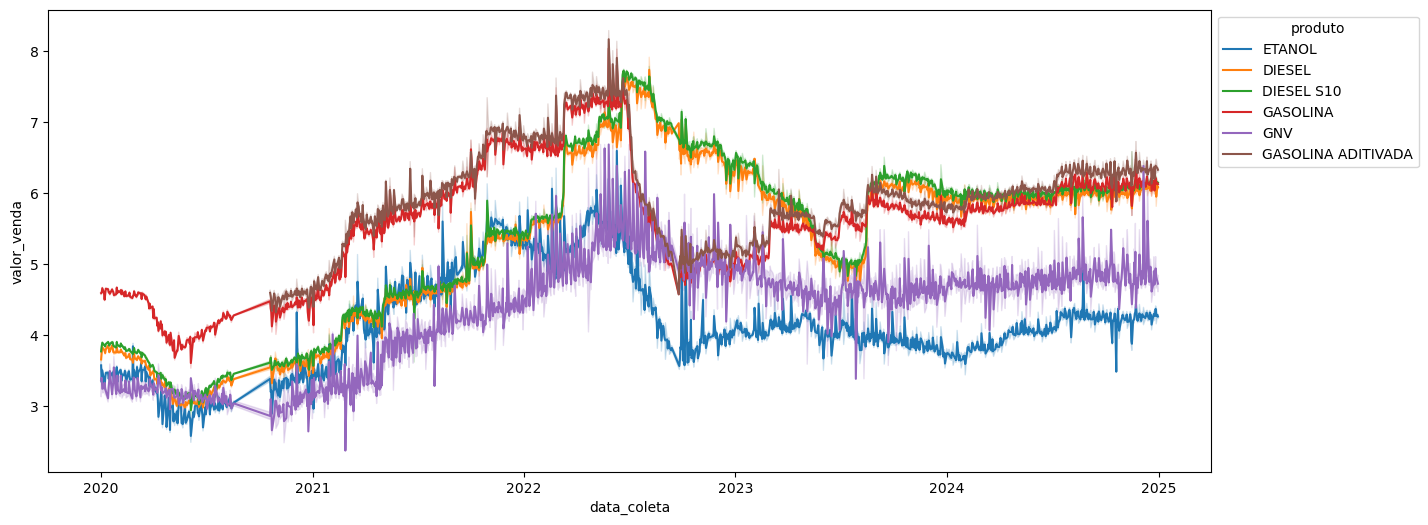

In [36]:
# Gerar grafico Lineplot
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data = df_anp, x="data_coleta", y ='valor_venda', hue="produto")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [37]:
# Separar o data set por tipo de produto
gasolina_aditivada = df_anp.loc[df['produto']=='GASOLINA ADITIVADA'].copy()
gasolina = df_anp.loc[df['produto']=='GASOLINA'].copy()
diesel_s10 = df_anp.loc[df['produto']=='DIESEL S10'].copy()
diesel = df_anp.loc[df['produto']=='DIESEL'].copy()
etanol = df_anp.loc[df['produto']=='ETANOL'].copy()
gnv = df_anp.loc[df['produto']=='GNV'].copy()

In [39]:
# Estatística básica --> Gasolina Aditivada
print('Gasolina Aditivada')
gasolina_aditivada.valor_venda.describe().round(2)

Gasolina Aditivada


count    701885.00
mean          6.05
std           0.75
min           3.46
25%           5.57
50%           5.99
75%           6.49
max           9.79
Name: valor_venda, dtype: float64

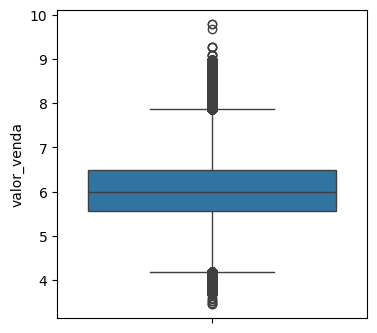

In [43]:
# Plotar boxplot
plotar_boxplot_geral('valor_venda', gasolina_aditivada)

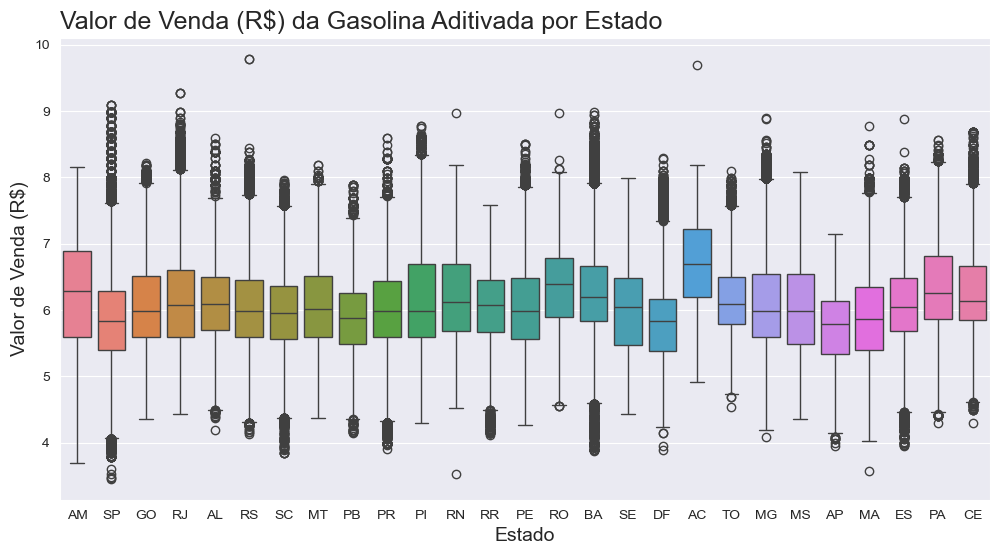

In [57]:
# Plotar boxplot
plotar_boxplot_2V(
        'Valor de Venda (R$) da Gasolina Aditivada por Estado',
        'Estado',
        'Valor de Venda (R$)',
        'estado',
        'valor_venda',
        gasolina_aditivada)

#### **Aula 5 - Dashboards e storytelling**